In [1]:
import gpytorch
import numpy as np
import torch
import winsound
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from LDGD.model import LDGD, FastLDGD, VAE
from LDGD.visualization.vizualize_utils import plot_heatmap, plot_2d_scatter, plot_ARD_gplvm
from LDGD.visualization.vizualize_utils import plot_loss_gplvm, plot_scatter_gplvm
from LDGD.data.data_loader import generate_data

from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood

from LDGD.utils import dicts_to_dict_of_lists
import json
%matplotlib inline
%load_ext autoreload
%autoreload 2
duration = 1000  # milliseconds
freq = 440  # Hz
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Functions

## 1- Create Dataset

In [2]:
def create_dataset(num_dimension, random_state, test_size, **kwargs):
    # Extract parameters for synthetic data generation
    pattern = kwargs.get('pattern', 'moon')  # default pattern
    n_samples = kwargs.get('n_samples', 1500)
    noise = kwargs.get('noise', 0.1)
    increase_method = kwargs.get('increase_method', 'linear')

    X, y, orig_data = generate_data(pattern, n_samples, noise, num_dimension, increase_method, random_state=random_state)
    # One-hot encode the labels
    y_one_hot = np.zeros((y.shape[0], len(np.unique(y))))
    y_one_hot[np.arange(y.shape[0]), np.uint(y)] = 1

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test, y_train_labels, y_test_labels = train_test_split(X, y_one_hot, y,
                                                                                       test_size=test_size,
                                                                                       random_state=random_state)
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    y_train_labels_tensor = torch.tensor(y_train_labels)
    y_test_labels_tensor = torch.tensor(y_test_labels)

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, y_train_labels_tensor, y_test_labels_tensor, orig_data

## 2 - Create Model

In [3]:
def create_LDGD_model(data_cont, data_cat, ldgd_settings, x_init='pca'):
    kernel_reg = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=ldgd_settings['latent_dim']))
    kernel_cls = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=ldgd_settings['latent_dim']))

    likelihood_reg = GaussianLikelihood(batch_shape=batch_shape)
    likelihood_cls = BernoulliLikelihood()
    model = LDGD(data_cont,
             kernel_reg=kernel_reg,
             kernel_cls=kernel_cls,
             num_classes=data_cat.shape[-1],
             latent_dim=ldgd_settings['latent_dim'],
             num_inducing_points_cls= ldgd_settings['num_inducing_points_cls'],
             num_inducing_points_reg= ldgd_settings['num_inducing_points_reg'],
             likelihood_reg=likelihood_reg,
             likelihood_cls=likelihood_cls,
             use_gpytorch=ldgd_settings['use_gpytorch'],
             shared_inducing_points=ldgd_settings['shared_inducing_points'],
             use_shared_kernel=False,
             x_init=x_init,
             device=device)

    return model

def create_FastLDGD_model(data_cont, data_cat, ldgd_settings):
    kernel_reg = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=ldgd_settings['latent_dim']))
    kernel_cls = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=ldgd_settings['latent_dim']))

    likelihood_reg = GaussianLikelihood(batch_shape=batch_shape)
    likelihood_cls = BernoulliLikelihood()
    model = FastLDGD(data_cont,
             kernel_reg=kernel_reg,
             kernel_cls=kernel_cls,
             num_classes=data_cat.shape[-1],
             latent_dim=ldgd_settings['latent_dim'],
             num_inducing_points_cls= ldgd_settings['num_inducing_points_cls'],
             num_inducing_points_reg= ldgd_settings['num_inducing_points_reg'],
             likelihood_reg=likelihood_reg,
             likelihood_cls=likelihood_cls,
             use_gpytorch=ldgd_settings['use_gpytorch'],
             shared_inducing_points=ldgd_settings['shared_inducing_points'],
             use_shared_kernel=False,
             device=device)

    return model

# Task 1 : Evaluate model on different synthetic data

## 1.1 settings

In [8]:
model_settings = {
    'latent_dim': 2,
    'num_inducing_points': 5,
    'num_inducing_points_reg': 8,
    'num_inducing_points_cls': 8,
    'num_epochs_train': 2000,
    'num_epochs_test': 2000,
    'batch_size': 100,
    'load_trained_model': False,
    'load_tested_model': False,
    'dataset': 'synthetic',
    'shared_inducing_points': True,
    'use_gpytorch': True,
    'random_state': 65,
    'test_size': 0.8,
    'cls_weight': 1.0,
    'reg_weight': 1.0,
    'num_samples': 500,

}
np.random.seed(model_settings['random_state'])
torch.manual_seed(model_settings['random_state'])

## 1.2 Train Model

In [9]:
load_saved_result = False
save_model = True
model_list = []
for num_dimension in [5, 10, 20]:
    yn_train, yn_test, ys_train, ys_test, labels_train, labels_test, orig_dataset = create_dataset(num_dimension=num_dimension,
                                                                                                   random_state= model_settings['random_state'],
                                                                                                   test_size=model_settings['test_size'],
                                                                                                   n_samples=model_settings['num_samples'])
    model_settings['data_dim'] = yn_train.shape[-1]
    batch_shape = torch.Size([model_settings['data_dim']])
    if load_saved_result is False:
        model = create_LDGD_model(yn_train, ys_train, model_settings, x_init='pca')

        losses, history_train = model.train_model(yn=yn_train, ys=ys_train,
                                                  epochs=model_settings['num_epochs_train'],
                                                  batch_size=model_settings['batch_size'])
        if save_model is True:
            model.save_wights(file_name=f"model_synthetic_{num_dimension}")
        predictions, metrics, history_test = model.evaluate(yn_test=yn_test, ys_test=labels_test,
                                                        epochs=model_settings['num_epochs_test'])

        winsound.Beep(freq, duration)
    else:
        model = create_LDGD_model(yn_train, ys_train, model_settings)
        model.load_weights(path_save='', file_name=f'model_synthetic_{num_dimension}.pth')
        predictions, metrics, history_test = model.evaluate(yn_test=yn_test, ys_test=labels_test,
                                                        epochs=model_settings['num_epochs_test'])
    model_list.append(model)

winsound.Beep(freq, duration*3)


Epoch 1/2000, Loss: 16.02266502380371, MSE: 0.2328771948814392
Epoch 11/2000, Loss: 14.263845443725586, MSE: 0.15790408849716187
Epoch 21/2000, Loss: 12.790742874145508, MSE: 0.10467378050088882
Epoch 31/2000, Loss: 11.629050254821777, MSE: 0.0777372270822525
Epoch 41/2000, Loss: 10.82294750213623, MSE: 0.0680619478225708
Epoch 51/2000, Loss: 9.85718059539795, MSE: 0.06580036878585815
Epoch 61/2000, Loss: 9.147077560424805, MSE: 0.06581033021211624
Epoch 71/2000, Loss: 8.441537857055664, MSE: 0.06549220532178879
Epoch 81/2000, Loss: 7.886754035949707, MSE: 0.06436221301555634
Epoch 91/2000, Loss: 7.185717582702637, MSE: 0.06417693942785263
Epoch 101/2000, Loss: 6.678928375244141, MSE: 0.06328094005584717
Epoch 111/2000, Loss: 5.876029968261719, MSE: 0.06235037371516228
Epoch 121/2000, Loss: 5.569197177886963, MSE: 0.0616430789232254
Epoch 131/2000, Loss: 4.989480495452881, MSE: 0.06155867874622345
Epoch 141/2000, Loss: 4.5247931480407715, MSE: 0.06141626834869385
Epoch 151/2000, Loss: 

## 1.3 visualize

 D:\Navid\Projects\LDGD\src\LDGD\visualization\vizualize_utils.py:217: UserWarning:The following kwargs were not used by contour: 'label'


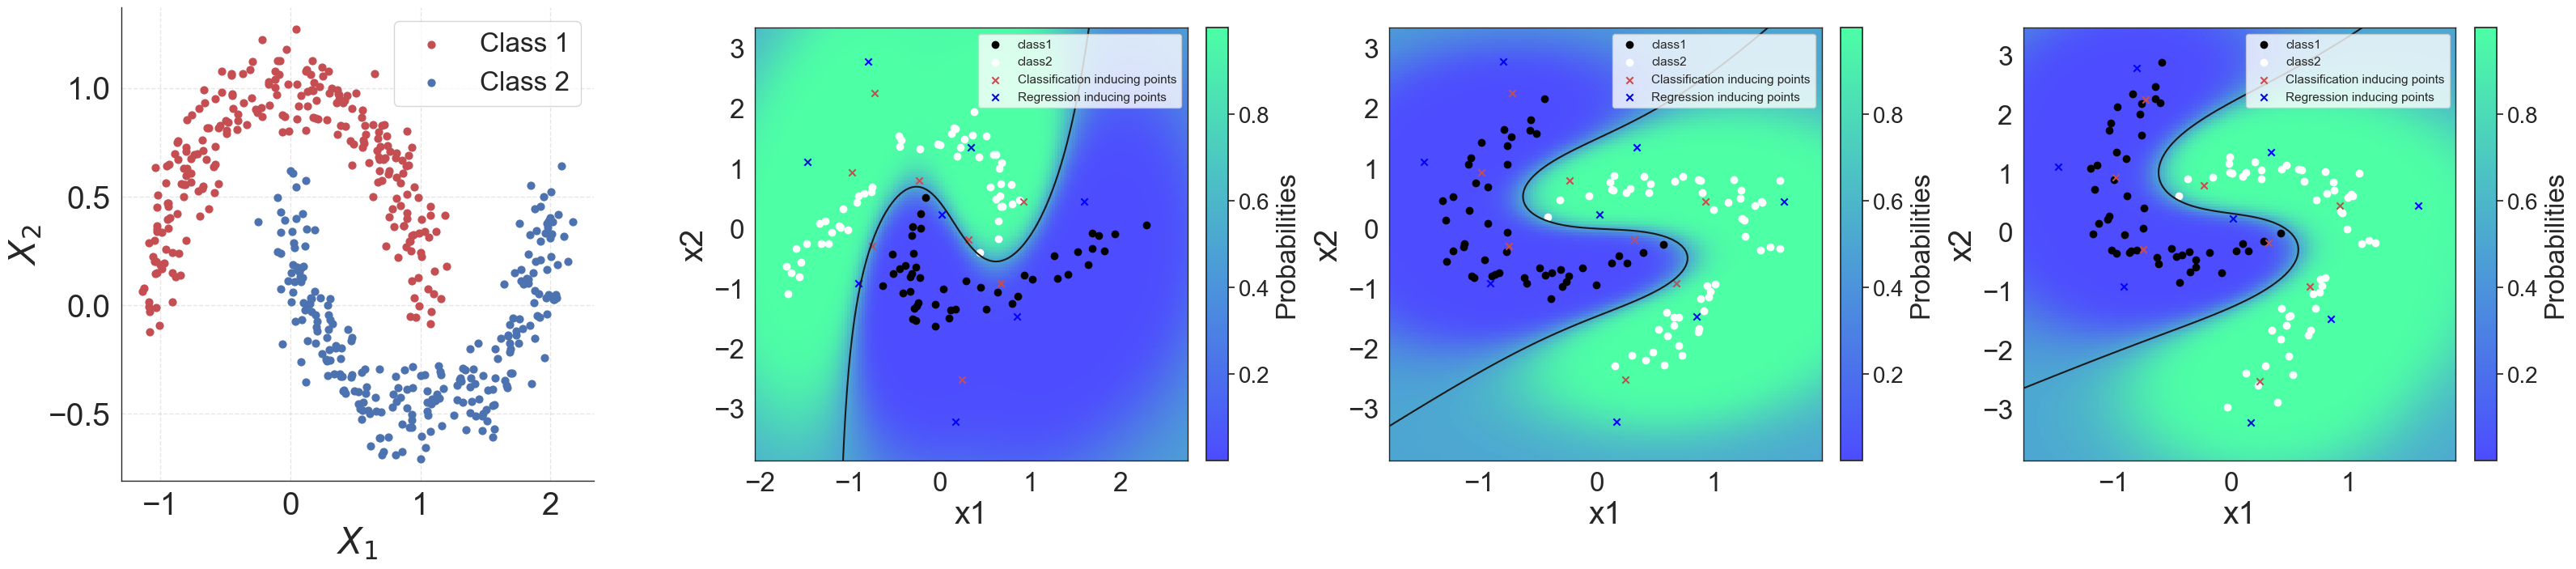

In [10]:
fig, axs = plt.subplots(1,4, figsize=(32, 8))
x_org, y_org = orig_dataset
plot_2d_scatter(x_org, y_org, ax = axs[0])
# [left, bottom, width, height]
for idx , model in enumerate(model_list):
    alpha_reg = 1 / model.kernel_reg.base_kernel.lengthscale.cpu().detach().numpy()
    alpha_cls = 1 / model.kernel_cls.base_kernel.lengthscale.cpu().detach().numpy()

    x = model.x.q_mu.cpu().detach().numpy()
    std = torch.nn.functional.softplus(model.x.q_log_sigma).cpu().detach().numpy()

    x_test = model.x_test.q_mu.cpu().detach().numpy()
    std_test = torch.nn.functional.softplus(model.x_test.q_log_sigma).cpu().detach().numpy()

    inducing_points = (history_test['z_list_reg'][-1], history_test['z_list_cls'][-1])

    plot_heatmap(x, labels_train, model, alpha_cls, cmap='winter', range_scale=1.2,
             file_name='latent_heatmap_train', inducing_points=inducing_points, ax1=axs[idx+1], fig=fig)


plt.tight_layout()
fig.savefig("Compare_synthetic.png")
fig.savefig("Compare_synthetic.svg")


# Task 2: Train Model with larger Latent Dimension
## 2.1 Settings:

In [13]:
model_settings = {
    'latent_dim': 10,
    'num_inducing_points_reg': 25,
    'num_inducing_points_cls': 25,
    'num_epochs_train': 20000,
    'num_epochs_test': 20000,
    'batch_size': 100,
    'load_trained_model': False,
    'load_tested_model': False,
    'dataset': 'synthetic',
    'shared_inducing_points': False,
    'use_gpytorch': True,
    'random_state': 54,
    'test_size': 0.2
}

# 2.2 Training model

In [14]:
load_saved_result = True
yn_train, yn_test, ys_train, ys_test, labels_train, labels_test, orig_dataset = create_dataset(num_dimension=10,
                                                                                               random_state= model_settings['random_state'],
                                                                                               test_size=model_settings['test_size'])
model_settings['data_dim'] = yn_train.shape[-1]
model_settings['latent_dim'] = 10
batch_shape = torch.Size([model_settings['data_dim']])


model = create_LDGD_model(yn_train, ys_train, model_settings, x_init='pca')

if load_saved_result is False:
    losses, history_train = model.train_model(yn=yn_train, ys=ys_train,
                                              epochs=model_settings['num_epochs_train'],
                                              batch_size=model_settings['batch_size'])
    winsound.Beep(freq, duration*3)
    model.save_wights(path_save='', file_name=f'model_task2.pth')
else:
    model.load_weights(path_save='', file_name=f'model_task2.pth')


Epoch 1/20000, Loss: 32.160762786865234
Epoch 11/20000, Loss: 30.975116729736328
Epoch 21/20000, Loss: 30.581026077270508
Epoch 31/20000, Loss: 29.427175521850586
Epoch 41/20000, Loss: 28.39651870727539
Epoch 51/20000, Loss: 27.447078704833984
Epoch 61/20000, Loss: 26.88933563232422
Epoch 71/20000, Loss: 25.095691680908203
Epoch 81/20000, Loss: 23.8709774017334
Epoch 91/20000, Loss: 22.37493324279785
Epoch 101/20000, Loss: 21.618494033813477
Epoch 111/20000, Loss: 19.736417770385742
Epoch 121/20000, Loss: 18.72906494140625
Epoch 131/20000, Loss: 17.491130828857422
Epoch 141/20000, Loss: 16.099746704101562
Epoch 151/20000, Loss: 14.656547546386719
Epoch 161/20000, Loss: 13.4069242477417
Epoch 171/20000, Loss: 12.333020210266113
Epoch 181/20000, Loss: 12.021638870239258
Epoch 191/20000, Loss: 10.505742073059082
Epoch 201/20000, Loss: 9.542986869812012
Epoch 211/20000, Loss: 8.313704490661621
Epoch 221/20000, Loss: 8.035216331481934
Epoch 231/20000, Loss: 7.79890775680542
Epoch 241/20000,

## 2.3 Evaluating model

In [15]:

predictions, metrics, history_test = model.evaluate(yn_test=yn_test, ys_test=labels_test,
                                                epochs=5000)

alpha_reg = 1 / model.kernel_reg.base_kernel.lengthscale.cpu().detach().numpy()
alpha_cls = 1 / model.kernel_cls.base_kernel.lengthscale.cpu().detach().numpy()

x = model.x.q_mu.cpu().detach().numpy()
std = torch.nn.functional.softplus(model.x.q_log_sigma).cpu().detach().numpy()

x_test = model.x_test.q_mu.cpu().detach().numpy()
std_test = torch.nn.functional.softplus(model.x_test.q_log_sigma).cpu().detach().numpy()
winsound.Beep(freq, duration*3)

Epoch 1/5000, Loss: 8665.0146484375
Epoch 11/5000, Loss: 8460.4501953125
Epoch 21/5000, Loss: 10015.986328125
Epoch 31/5000, Loss: 9614.4287109375
Epoch 41/5000, Loss: 9434.009765625
Epoch 51/5000, Loss: 8983.9404296875
Epoch 61/5000, Loss: 7728.19921875
Epoch 71/5000, Loss: 7884.69140625
Epoch 81/5000, Loss: 7173.72900390625
Epoch 91/5000, Loss: 6761.7529296875
Epoch 101/5000, Loss: 7293.03759765625
Epoch 111/5000, Loss: 5769.50537109375
Epoch 121/5000, Loss: 5902.66650390625
Epoch 131/5000, Loss: 5637.7548828125
Epoch 141/5000, Loss: 5550.9091796875
Epoch 151/5000, Loss: 4699.61474609375
Epoch 161/5000, Loss: 4724.18310546875
Epoch 171/5000, Loss: 4598.4501953125
Epoch 181/5000, Loss: 4522.6572265625
Epoch 191/5000, Loss: 4318.921875
Epoch 201/5000, Loss: 4205.4853515625
Epoch 211/5000, Loss: 4403.775390625
Epoch 221/5000, Loss: 3475.258544921875
Epoch 231/5000, Loss: 4352.32080078125
Epoch 241/5000, Loss: 3736.537841796875
Epoch 251/5000, Loss: 3579.871337890625
Epoch 261/5000, Loss

## 2.4 Visualizing results

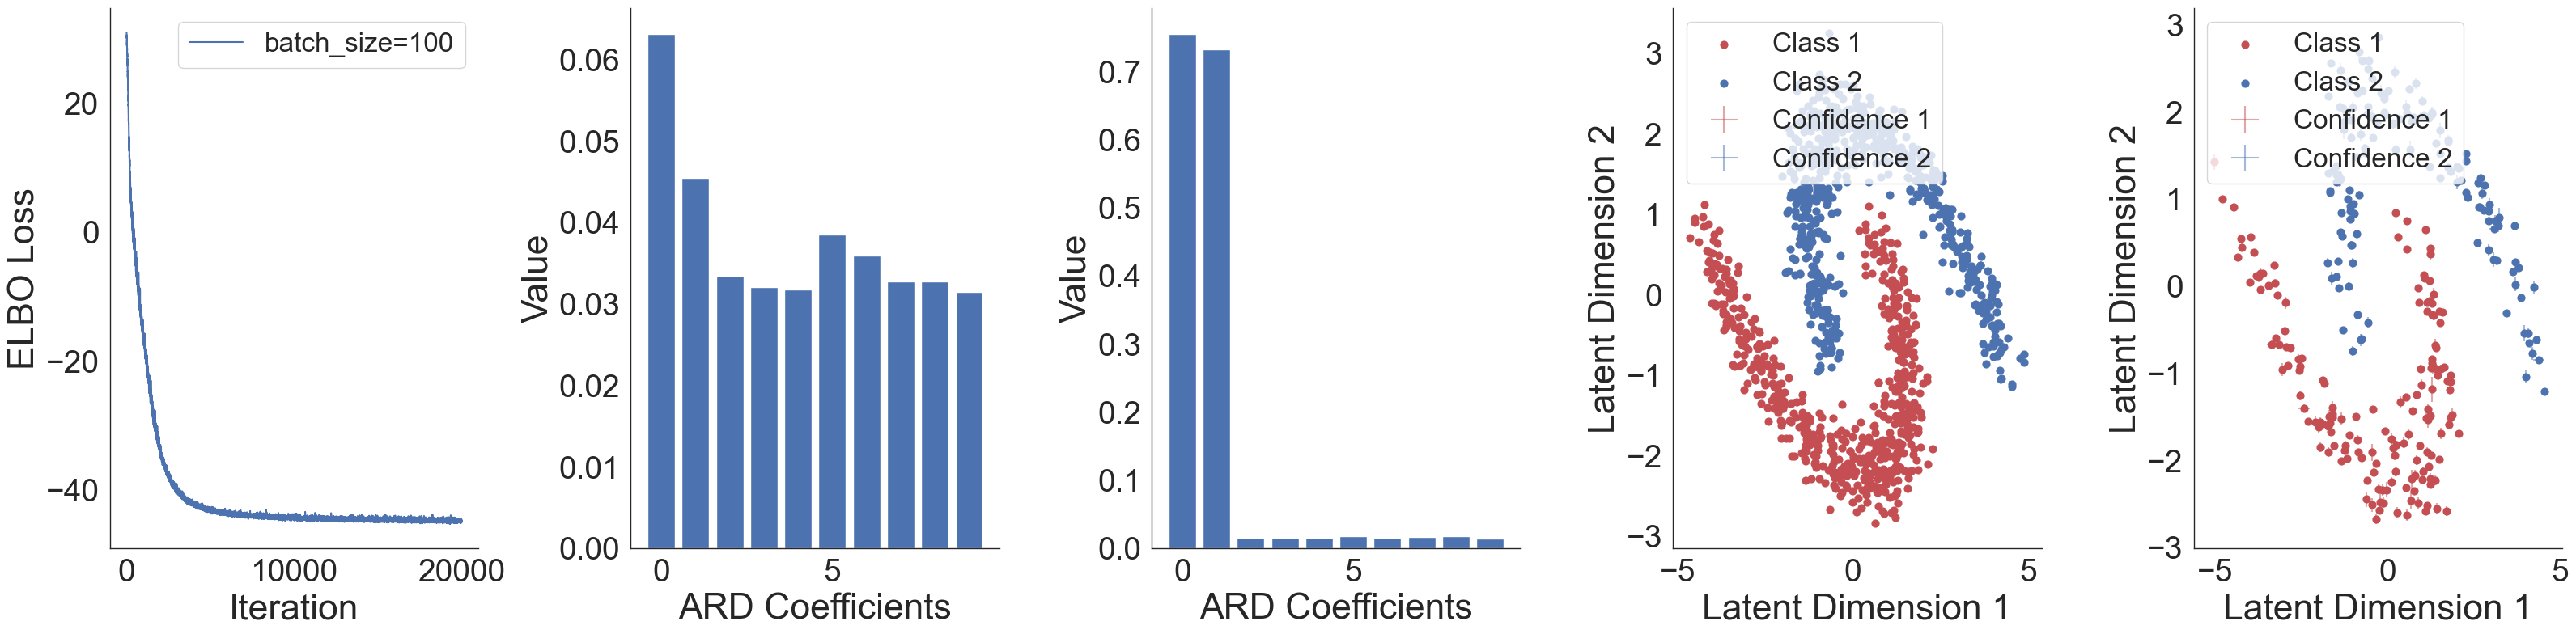

In [16]:
latent_dim = x.shape[-1]
values, indices = torch.topk(torch.tensor(alpha_cls), k=2, largest=True)
l1 = indices.numpy().flatten()[0]
l2 = indices.numpy().flatten()[1]

fig, axs = plt.subplots(1,5, figsize=(32, 8))


plot_loss_gplvm(losses, ax=axs[0])
plot_ARD_gplvm(latent_dim, alpha_cls, ax=axs[2])
plot_ARD_gplvm(latent_dim, alpha_reg, ax=axs[1])
plot_scatter_gplvm(x, labels_train, l1=l1, l2=l2, ax=axs[3], colors=['r', 'b', 'g'], show_errorbars=True, std=std)
plot_scatter_gplvm(x_test, labels_test, l1=l1, l2=l2, ax=axs[4], colors=['r', 'b', 'g'], show_errorbars=True, std=std_test)
plt.tight_layout()
fig.savefig("ARD_synthetic.png")
fig.savefig("ARD_synthetic.svg")

# Task 3: Compare LDGD Results with VAE
## 3.1 Settings:

In [11]:
model_settings = {
    'latent_dim': 2,
    'num_inducing_points_reg': 5,
    'num_inducing_points_cls': 5,
    'num_epochs_train': 10000,
    'num_epochs_test': 5000,
    'batch_size': 100,
    'load_trained_model': False,
    'load_tested_model': False,
    'dataset': 'synthetic',
    'shared_inducing_points': True,
    'use_gpytorch': True,
    'random_state': 54,
    'test_size': 0.3,
    'use_shared_kernel': False
}

## 3.2 Create Dataset

In [12]:
yn_train, yn_test, ys_train, ys_test, labels_train, labels_test, orig_dataset = create_dataset(num_dimension=10,
                                                                                               random_state= model_settings['random_state'],
                                                                                               test_size=model_settings['test_size'])

print(f"train size = {yn_train.shape[0]}")
print(f"test size = {ys_test.shape[0]}")

list_size = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
load_saved_result = False


train size = 1050
test size = 450


## 3.3 Training model

In [4]:
try:
    with open('metric_vae_dict.json', 'r') as file:
        metric_vae_dict = json.load(file)
except:
    batch_shape = torch.Size([yn_train.shape[-1]])
    metric_vae_list = []
    for train_size in list_size:
        print(f"Training for sample size: {train_size}")
        yn_train_limited, ys_train_limited, labels_train_limited = yn_train[:train_size], ys_train[:train_size], labels_train[:train_size]

        # Train VAE Model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = VAE(input_dim=yn_train_limited.shape[-1],
                    hidden_dim=50,
                    latent_dim=2,
                    num_classes=len(np.unique(labels_train))).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        model.fit(x=yn_train_limited, y=labels_train_limited, x_test=yn_test, y_test=labels_test, optimizer=optimizer, epochs=2000, batch_size=500, patience=50)
        x_hat, y_hat, mean, log_var, metrics = model.evaluate(yn_test, labels_test)

        metric_vae_list.append(metrics)
    winsound.Beep(freq, duration*3)
    metric_vae_dict = dicts_to_dict_of_lists(metric_vae_list)
    with open('metric_vae_dict.json', 'w') as file:
        json.dump(metric_vae_dict, file, indent=4)

In [8]:
try:
    with open('metric_ldgd_dict.json', 'r') as file:
        metric_ldgd_dict = json.load(file)
except:
    batch_shape = torch.Size([yn_train.shape[-1]])
    metric_ldgd_list = []
    for train_size in list_size:
        model_settings['num_inducing_points_reg']= np.max([int(train_size/10) + 5, 25])
        model_settings['num_inducing_points_cls']= np.max([int(train_size/10) + 5, 25])
        yn_train_limited, ys_train_limited, labels_train_limited = yn_train[:train_size], ys_train[:train_size], labels_train[:train_size]
        # Train LDGD Model
        model = create_LDGD_model(yn_train_limited, ys_train_limited, model_settings)
        if load_saved_result is False:
            losses, history_train = model.train_model(yn=yn_train_limited, ys=ys_train_limited,
                                                      epochs=model_settings['num_epochs_train'],
                                                      batch_size=model_settings['batch_size'],
                                                      early_stop=1e-6)
            model.save_wights(path_save='', file_name=f"model_ldgd_task3_{train_size}")
        else:
            model.load_weights(path_save='', file_name=f"model_ldgd_task3_{train_size}")

        predictions, metrics, history_test = model.evaluate(yn_test=yn_test, ys_test=labels_test,
                                                        epochs=model_settings['num_epochs_test'])

        metric_ldgd_list.append(metrics)
    winsound.Beep(freq, duration*3)
    metric_ldgd_dict = dicts_to_dict_of_lists(metric_ldgd_list)
    with open('metric_ldgd_dict.json', 'w') as file:
        json.dump(metric_ldgd_dict, file, indent=4)

In [6]:
try:
    with open('metric_fastldgd_dict.json', 'r') as file:
        metric_fastldgd_dict = json.load(file)
except:
    batch_shape = torch.Size([yn_train.shape[-1]])
    metric_fastldgd_list = []
    for train_size in list_size:
        print(f"\n ===== train size - {train_size} ======")
        model_settings['num_inducing_points_reg']= np.max([int(train_size/10) + 5, 25])
        model_settings['num_inducing_points_cls']= np.max([int(train_size/10) + 5, 25])
        yn_train_limited, ys_train_limited, labels_train_limited = yn_train[:train_size], ys_train[:train_size], labels_train[:train_size]
        # Train LDGD Model
        model = create_FastLDGD_model(yn_train_limited, ys_train_limited, model_settings)
        if load_saved_result is False:
            losses, history_train = model.train_model(yn=yn_train_limited, ys=ys_train_limited,
                                                      epochs=model_settings['num_epochs_train'],
                                                      batch_size=model_settings['batch_size'])
            model.save_wights(path_save='', file_name=f"model_fldgd_task3_{train_size}")
        else:
            try:
                model.load_weights(path_save='', file_name=f"model_fldgd_task3_{train_size}")
            except:
                losses, history_train = model.train_model(yn=yn_train_limited, ys=ys_train_limited,
                                                      epochs=model_settings['num_epochs_train'],
                                                      batch_size=model_settings['batch_size'])
                model.save_wights(path_save='', file_name=f"model_fldgd_task3_{train_size}")


        predictions, metrics, history_test = model.evaluate(yn_test=yn_test, ys_test=labels_test,
                                                        epochs=model_settings['num_epochs_test'])

        metric_fastldgd_list.append(metrics)
    winsound.Beep(freq, duration*3)
    metric_fastldgd_dict = dicts_to_dict_of_lists(metric_fastldgd_list)
    with open('metric_fastldgd_dict.json', 'w') as file:
        json.dump(metric_fastldgd_dict, file, indent=4)

## Visualize

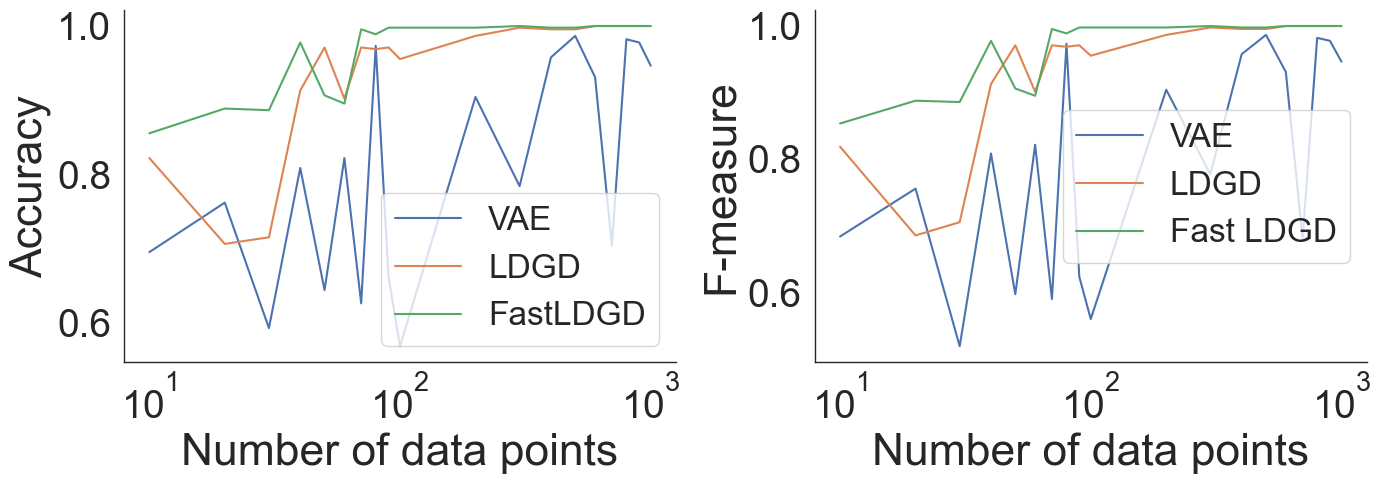

In [13]:

AXIS_LABEL_FONTSIZE = 32
TICKS_LABEL_FONTSIZE = 28
LEGEND_FONTSIZE = 24



fig, axes = plt.subplots(1,2, figsize=(14, 5))
# ax1.set_title('2D Latent Subspace Corresponding to 3 Phase Oilflow', fontsize=32)

axes[0].plot(list_size, metric_vae_dict['accuracy'], label='VAE')
axes[0].plot(list_size, metric_ldgd_dict['accuracy'], label='LDGD')
axes[0].plot(list_size, metric_fastldgd_dict['accuracy'], label='FastLDGD')

axes[0].set_xlabel(f'Number of data points', fontsize=AXIS_LABEL_FONTSIZE)
axes[0].set_ylabel(f'Accuracy', fontsize=AXIS_LABEL_FONTSIZE)
axes[0].tick_params(axis='both', labelsize=TICKS_LABEL_FONTSIZE)
# Applying consistent spines format
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_linewidth(1)
axes[0].spines['bottom'].set_linewidth(1)
axes[0].legend(fontsize=LEGEND_FONTSIZE)
axes[0].set_xscale('log')  # Making x-axis logarithmic for the accuracy plot


axes[1].plot(list_size, metric_vae_dict['f1_score'], label='VAE')
axes[1].plot(list_size, metric_ldgd_dict['f1_score'], label='LDGD')
axes[1].plot(list_size, metric_fastldgd_dict['f1_score'], label='Fast LDGD')

axes[1].set_xlabel(f'Number of data points', fontsize=AXIS_LABEL_FONTSIZE)
axes[1].set_ylabel(f'F-measure', fontsize=AXIS_LABEL_FONTSIZE)
axes[1].tick_params(axis='both', labelsize=TICKS_LABEL_FONTSIZE)
# Applying consistent spines format
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_linewidth(1)
axes[1].spines['bottom'].set_linewidth(1)
axes[1].legend(fontsize=LEGEND_FONTSIZE)
axes[1].set_xscale('log')  # Making x-axis logarithmic for the accuracy plot

plt.tight_layout()
fig.savefig("task3.png")
fig.savefig("task3.svg")

plt.show()